In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer,MissingIndicator
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler,PowerTransformer,OrdinalEncoder
from sklearn.model_selection import train_test_split
!pip install missingno
import missingno as mns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
import time

In [2]:
%pip install -q dagshub mlflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import mlflow
import dagshub
print('mlflow_version:',mlflow.__version__)
print('dagshub_version:',dagshub.__version__)

mlflow_version: 2.22.1
dagshub_version: 0.5.10


In [4]:
import dagshub
dagshub.init(repo_owner='vkyadav7635', repo_name='Swiggy-Delivery-Time-Prediction', mlflow=True)

Accessing as vkyadav7635

Initialized MLflow to track repo "vkyadav7635/Swiggy-Delivery-Time-Prediction"

Repository vkyadav7635/Swiggy-Delivery-Time-Prediction initialized!

In [5]:
mlflow.set_tracking_uri("https://dagshub.com/vkyadav7635/Swiggy-Delivery-Time-Prediction.mlflow")

In [6]:
# mlflow experiment

mlflow.set_experiment("Exp 4 - Final Estimator")

2025/07/13 19:07:05 INFO mlflow.tracking.fluent: Experiment with name 'Exp 4 - Final Estimator' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/2147cf0c46354429b5c82f1760b8ef5a', creation_time=1752413829972, experiment_id='3', last_update_time=1752413829972, lifecycle_stage='active', name='Exp 4 - Final Estimator', tags={}>

In [7]:
from sklearn import set_config

set_config(transform_output="pandas")

# Load the Data

In [8]:
# load the data

df = pd.read_csv('swiggy.csv')

df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [9]:
df.shape

(45593, 20)

# Clean Data

In [10]:
# load the cleaned data

df = pd.read_csv('swiggy_imputed_data.csv')

df.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time,order_time_of_day,distance
0,37.0,4.9,sunny,high,2,snack,motorcycle,0,no,urban,24.0,INDO,19,3,Saturday,True,15.0,morning,3.03
1,34.0,4.5,stormy,jam,2,snack,scooter,1,no,metropolitian,33.0,BANG,25,3,Friday,False,5.0,night,20.18
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1,no,urban,26.0,BANG,19,3,Saturday,True,15.0,morning,1.55
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1,no,metropolitian,21.0,COIMB,5,4,Tuesday,False,10.0,evening,7.79
4,32.0,4.6,cloudy,high,1,snack,scooter,1,no,metropolitian,30.0,CHEN,26,3,Saturday,True,15.0,afternoon,6.21


In [11]:
df.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time', 'order_time_of_day',
       'distance'],
      dtype='object')

In [12]:

columns_to_drop =  ["order_day","city_name","order_day_of_week","order_month"]

df.drop(columns=columns_to_drop, inplace=True)

df.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time,order_time_of_day,distance
0,37.0,4.9,sunny,high,2,snack,motorcycle,0,no,urban,24.0,True,15.0,morning,3.03
1,34.0,4.5,stormy,jam,2,snack,scooter,1,no,metropolitian,33.0,False,5.0,night,20.18
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1,no,urban,26.0,True,15.0,morning,1.55
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1,no,metropolitian,21.0,False,10.0,evening,7.79
4,32.0,4.6,cloudy,high,1,snack,scooter,1,no,metropolitian,30.0,True,15.0,afternoon,6.21


In [13]:
df.duplicated().sum()

3

In [14]:
df.drop_duplicates(keep='first',inplace=True)

<Axes: >

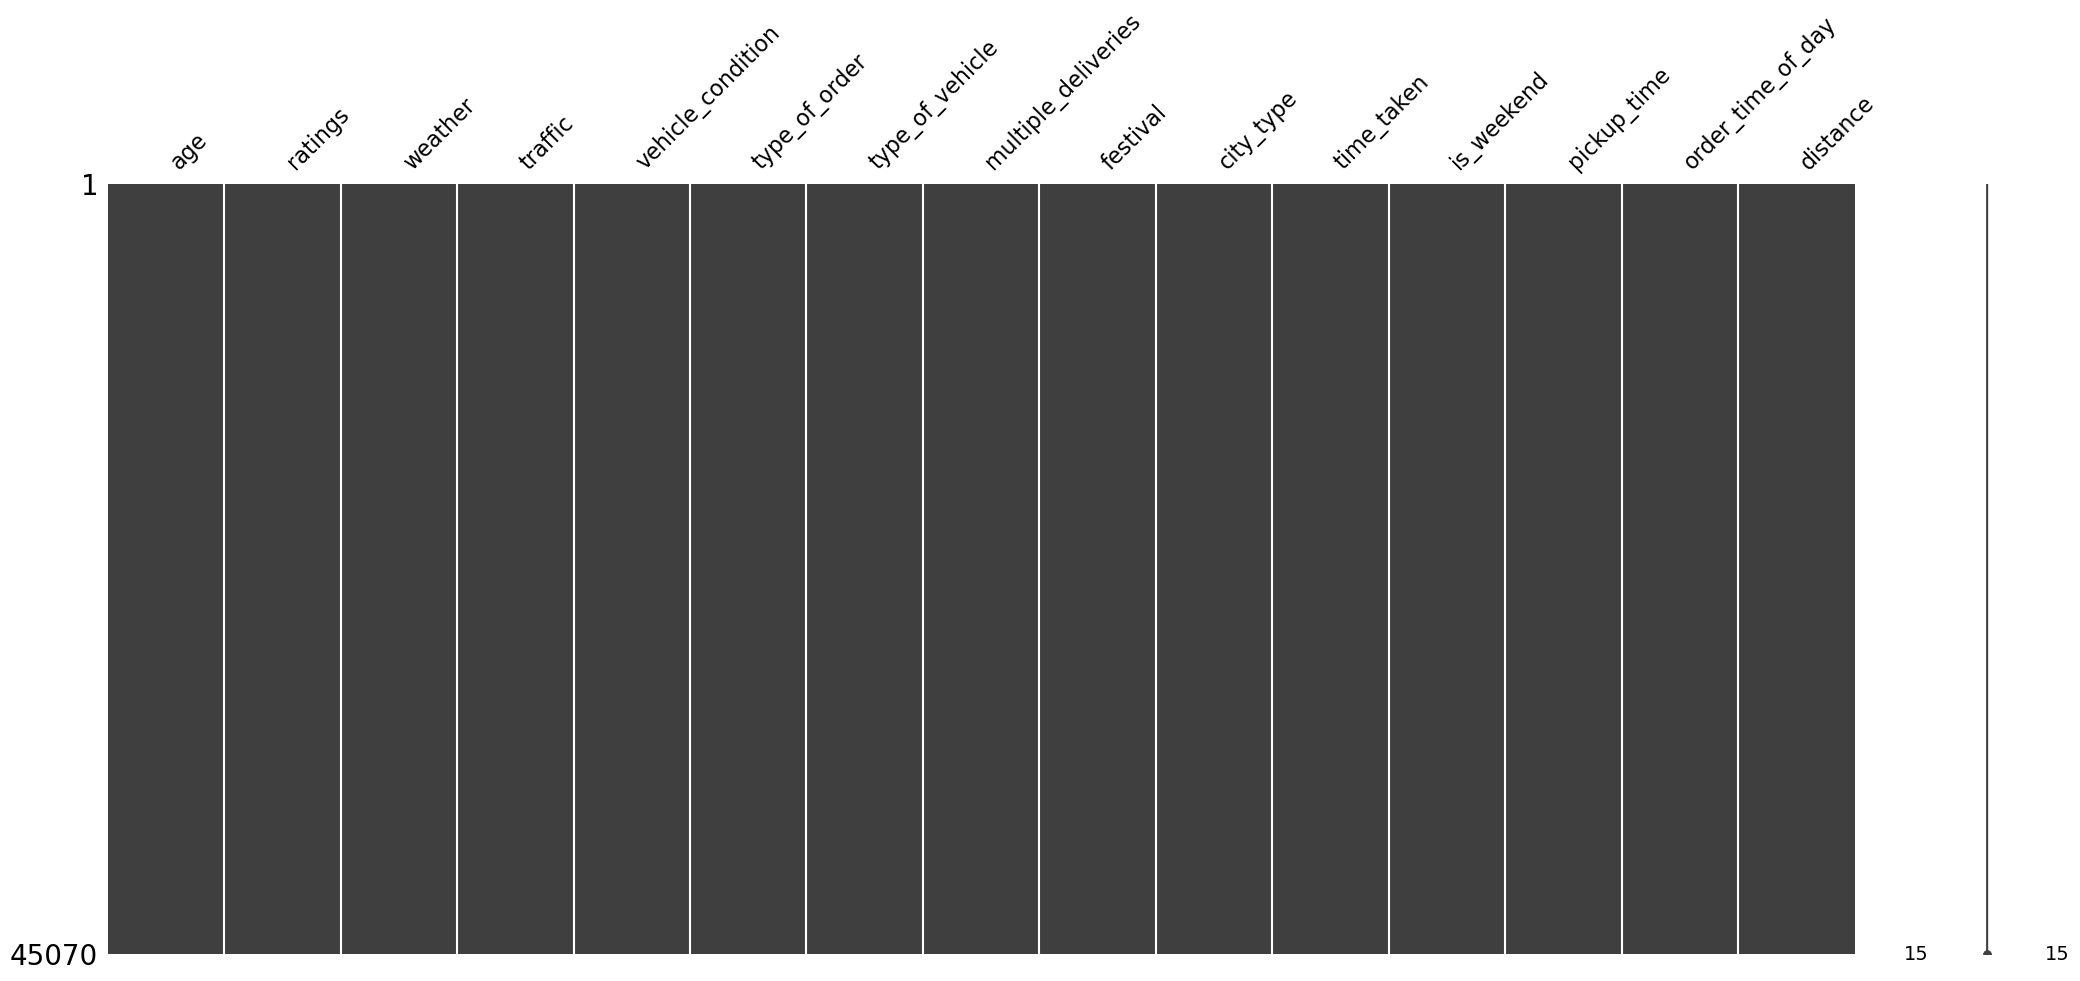

In [15]:
import missingno as msno

msno.matrix(df)

In [16]:
# split into X and y

X = df.drop(columns='time_taken')
y = df['time_taken']


In [17]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (36056, 14)
The shape of test data is (9014, 14)


In [19]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

# Pre-Processing Pipeline

In [20]:
num_cols = [ "age", "ratings", "pickup_time", "distance"]
    
nominal_cat_cols = [ "weather","type_of_order","type_of_vehicle","festival"] 
                   # "multiple_deliveries","vehicle_condition","is_weekend"

ordinal_cat_cols = ["traffic",'city_type','order_time_of_day']  

In [21]:
traffic_order = ["low","medium","high","jam"]
city_type_order = ['semi-urban','urban','metropolitian']
order_time_of_day_order = ['morning','afternoon','evening','night','late_night']

In [22]:

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",sparse_output=False), nominal_cat_cols),
    
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,city_type_order,order_time_of_day_order]), ordinal_cat_cols)
     ],
    remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

preprocessor.set_output(transform="pandas")

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [23]:

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

X_train_trans.head()

C:\Users\vkyad\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,age,ratings,pickup_time,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,type_of_order_snack,type_of_vehicle_motorcycle,type_of_vehicle_scooter,festival_yes,traffic,city_type,order_time_of_day,vehicle_condition,multiple_deliveries,is_weekend
28624,1.000000,0.80,0.0,0.162051,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,3.0,2.0,3.0,1,0,False
18848,0.789474,0.88,0.5,0.782051,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,3.0,2.0,3.0,2,1,True
33187,0.894737,0.88,1.0,0.238974,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,2.0,1.0,1.0,1,1,False
23417,0.368421,1.00,0.0,0.641026,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,2.0,4.0,0,1,False
39270,0.842105,0.84,0.5,0.643590,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.0,4.0,2,1,False


In [24]:
!pip install optuna

In [25]:
from lightgbm import LGBMRegressor
import optuna

In [34]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [35]:
# build the best models

best_rf_params = {'n_estimators': 479,
 'criterion': 'squared_error',
 'max_depth': 17,
 'max_features': None,
 'min_samples_split': 9,
 'min_samples_leaf': 2,
 'max_samples': 0.6603673526197067}

best_lgbm_params = {'n_estimators': 154,
 'max_depth': 27,
 'learning_rate': 0.22234435854395157,
 'subsample': 0.7592213724048168,
 'min_child_weight': 20,
 'min_split_gain': 0.004604680609280751,
 'reg_lambda': 97.81002379097947}

best_rf = RandomForestRegressor(**best_rf_params)
best_lgbm = LGBMRegressor(**best_lgbm_params)

lr = LinearRegression()

In [36]:
# build the stacking regressor

stacking_reg = StackingRegressor(estimators=[("rf",best_rf),
                                            ("lgbm",best_lgbm)],
                                final_estimator=lr,
                                cv=5,n_jobs=-1)

# build transformed regressor

model = TransformedTargetRegressor(regressor=stacking_reg,
                                    transformer=pt)

# train the model
model.fit(X_train_trans,y_train)
  

C:\Users\vkyad\anaconda3\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


,regressor,"StackingRegre...(), n_jobs=-1)"
,transformer,PowerTransformer()
,func,None
,inverse_func,None
,check_inverse,True
,n_estimators,479
,criterion,'squared_error'
,max_depth,17
,min_samples_split,9
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0


In [37]:
# get the train and test predictions

y_train_pred = model.predict(X_train_trans)
y_test_pred = model.predict(X_test_trans)

# calculate the train and test mae

train_mae = mean_absolute_error(y_train,y_train_pred)
test_mae = mean_absolute_error(y_test,y_test_pred)

# calculate the r2 scores

train_r2 = r2_score(y_train,y_train_pred)
test_r2 = r2_score(y_test,y_test_pred)

# calculate cross val scores

cv_scores = cross_val_score(model,
                            X_train_trans,
                            y_train,cv=3,
                            scoring="neg_mean_absolute_error",
                            n_jobs=-1)

C:\Users\vkyad\anaconda3\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\vkyad\anaconda3\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [38]:
-cv_scores

array([3.21982562, 3.24926976, 3.20709534])

In [39]:
# log with mlflow

with mlflow.start_run():
    # set tags
    mlflow.set_tag("model","stacking regressor")

    # log parameters
    mlflow.log_params(stacking_reg.get_params())

    # log metrics
    mlflow.log_metric("train_mae",train_mae)
    mlflow.log_metric("test_mae",test_mae)
    mlflow.log_metric("train_r2",train_r2)
    mlflow.log_metric("test_r2",test_r2)
    mlflow.log_metric("cv_score",-(cv_scores.mean()))

    # log the stacking regressor
    mlflow.sklearn.log_model(stacking_reg,"model")

2025/07/13 19:14:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run fun-lamb-128 at: https://dagshub.com/vkyadav7635/Swiggy-Delivery-Time-Prediction.mlflow/#/experiments/3/runs/228d9bf2916d48798f5fb282f8510cf5
🧪 View experiment at: https://dagshub.com/vkyadav7635/Swiggy-Delivery-Time-Prediction.mlflow/#/experiments/3
